# Key points classifier


## PREPARATION


### MOUNTING GOOGLE DRIVE
The first thing to do is to give google colab permission to access our drive so as to save the training checkpoints.

In [1]:
#MOUNTING GOOGLE DRIVE

from google.colab import drive
drive.mount('/content/gdrive',  force_remount=True) 

# force_remount is an argument to force google drive to mount once again.

Mounted at /content/gdrive


### DOWNLOAD The DATASET

Once we have finished our preprocessing, we have created a `dataset.zip` file from all the raw images. Now we download this file from our drive in order to start the training phase.

In [2]:
%%capture
# Download dataset from google drive

!gdown --id 1WQBOeqnxuv-XeB7qo1eCjN_TXaUyXtfX

# unzip the archive file
!unzip keypoints.zip

# we don't need the archive file anymore
!rm keypoints.zip

In [6]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pandas as pd
import os

RANDOM_SEED = 42


In [7]:
dataset = '/content/key_points.csv'
model_save_path = '/content/model/keypoint_classifier.hdf5'
os.mkdir('/content/model')

In [8]:
dataFrame = pd.read_csv(
        filepath_or_buffer=dataset,
        sep=',',
        header=None)

dataFrame.rename(columns={0: 'ground_truth'}, inplace=True)

In [9]:
dataFrame.shape

(5374, 43)

In [10]:
dataFrame.head()

,ground_truth,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0,0.0,0.0,-0.082437,-0.340502,-0.232975,-0.591398,-0.358423,-0.799283,-0.379928,...,-0.548387,-0.086022,-0.627240,0.096774,-0.709677,0.060932,-0.627240,0.057348,-0.544803,0.057348
1,0,0.0,0.0,-0.082437,-0.340502,-0.229391,-0.591398,-0.358423,-0.802867,-0.379928,...,-0.541219,-0.082437,-0.623656,0.096774,-0.713262,0.064516,-0.627240,0.057348,-0.544803,0.060932
2,0,0.0,0.0,-0.079137,-0.341727,-0.230216,-0.593525,-0.356115,-0.802158,-0.377698,...,-0.543165,-0.086331,-0.622302,0.093525,-0.708633,0.061151,-0.625899,0.053957,-0.543165,0.057554
3,0,0.0,0.0,-0.085409,-0.341637,-0.238434,-0.590747,-0.366548,-0.800712,-0.380783,...,-0.548043,-0.078292,-0.626335,0.103203,-0.708185,0.064057,-0.622776,0.056940,-0.544484,0.060498
4,0,0.0,0.0,-0.085409,-0.341637,-0.234875,-0.590747,-0.362989,-0.800712,-0.380783,...,-0.540925,-0.081851,-0.629893,0.092527,-0.704626,0.060498,-0.619217,0.056940,-0.540925,0.064057


In [16]:
class_names = pd.read_csv(
        filepath_or_buffer='/content/key_points_label.csv',
        sep='\n',
        header=None)

# class_names = ['Zero', 'One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight','Nine']
class_names

['Zero',
 'One',
 'Two',
 'Three',
 'Four',
 'Five',
 'Six',
 'Seven',
 'Eight',
 'Nine']

## LOAD AND GENERATION

Now we have everything to start the training phase,
Let's define some constants for our deep architecture. Each of the constants has its own application which is summarized in the table below:

CONSTANT_NAME | APPLICATION
-------------------|------------------
BATCH_SIZE       | # samples that will be passed through to the network at one time
N_CLASSES        | the output of the model, the classification layer of the model


In [11]:
BATCH_SIZE = 128
N_CLASSES = len(class_names)

In [12]:
# Separating target feature from the dataset. 
y = dataFrame['ground_truth']
X = dataFrame.drop(columns=['ground_truth'], axis=1)

## MODEL ARCHITECTURE AND TRAINING
While deep learning is certainly not new, it is experiencing explosive growth because of the intersection of deeply layered neural networks and the use of GPUs to accelerate their execution.

---
We decide to create a deep architecure to be able to train a model with good accuracy. To do so we are going to take the most use out of some callback function in the keras api.
- <b>`ModelCheckpoint`</b> 🏁: callback is used in conjunction with training using `model.fit()` to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.

- <b>`EarlyStopping` </b>🚦: Assuming the goal of a training is to minimize the loss. With this, the metric to be monitored would be `loss`, and mode would be `min`. A `model.fit()` training loop will check at end of every epoch whether the `loss` is no longer decreasing, considering the `min_delta` and patience if applicable. Once it's found no longer decreasing,the training terminates.

- <b> `ReduceLROnPlateau` </b> 𒑈: Models often benefit from reducing the learning rate by a factor of 2-10 once learning decreases. This callback monitors a quantity and if no improvement is seen for a `patience` number of epochs, the learning rate is reduced.


In [4]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

In [13]:
# reduces learning rate if no improvement are seen
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=1,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.000001)

# stop training if no improvements are seen
earlystopping_callback = EarlyStopping(monitor="val_loss",
                            mode="min",
                            patience=20,
                            restore_best_weights=True)

# saves model weights to file
checkpoint_callback = ModelCheckpoint(os.path.join('/content/model', 'cp-{epoch:04d}.h5'),
                            monitor='val_loss',
                            verbose=1,
                            save_best_only=True,
                            mode='min',
                            save_weights_only=True)


In [14]:
from sklearn.model_selection import train_test_split
import random


# divide train test: 75 % - 25 %
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state= RANDOM_SEED)

In [17]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(N_CLASSES, activation='softmax')
])

In [ ]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_6 (Dropout)         (None, 42)                0         
                                                                 
 dense_9 (Dense)             (None, 20)                860       
                                                                 
 dropout_7 (Dropout)         (None, 20)                0         
                                                                 
 dense_10 (Dense)            (None, 10)                210       
                                                                 
 dense_11 (Dense)            (None, 9)                 99        
                                                                 
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

### TRAINING


In [ ]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test),
    callbacks=[checkpoint_callback, earlystopping_callback]
)

Epoch 1/1000
19/32 [================>.............] - ETA: 0s - loss: 2.1908 - accuracy: 0.1616 
Epoch 1: saving model to /content/model/keypoint_classifier.hdf5
32/32 [==============================] - 1s 10ms/step - loss: 2.1796 - accuracy: 0.1650 - val_loss: 2.1117 - val_accuracy: 0.1763
Epoch 2/1000
21/32 [==================>...........] - ETA: 0s - loss: 2.1277 - accuracy: 0.1979
Epoch 2: saving model to /content/model/keypoint_classifier.hdf5
32/32 [==============================] - 0s 4ms/step - loss: 2.1150 - accuracy: 0.2074 - val_loss: 2.0477 - val_accuracy: 0.2850
Epoch 3/1000
22/32 [===================>..........] - ETA: 0s - loss: 2.0656 - accuracy: 0.2493
Epoch 3: saving model to /content/model/keypoint_classifier.hdf5
32/32 [==============================] - 0s 4ms/step - loss: 2.0557 - accuracy: 0.2529 - val_loss: 1.9605 - val_accuracy: 0.3259
Epoch 4/1000
22/32 [===================>..........] - ETA: 0s - loss: 1.9906 - accuracy: 0.2830
Epoch 4: saving model to /conten

In [ ]:
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)

11/11 [==============================] - 0s 2ms/step - loss: 0.2269 - accuracy: 0.9933


In [ ]:
model_save_path

'/content/model/keypoint_classifier.hdf5'

In [ ]:
model.save(model_save_path)

In [ ]:
model = tf.keras.models.load_model(model_save_path)

### Testing

In [ ]:
class_names[0].tolist()

['Like',
 'Dislike',
 'Call me',
 'Four',
 'Hi-five',
 'Victory',
 'Perfect',
 'Mamma Mia!',
 'Finger crossed']

In [ ]:
predict_result = model.predict(np.array([X_test.iloc[0]]))
print(['{:.1f}%'.format(i*100) for i in predict_result[0]])
print('predicted_class: ', 
    class_names[0].tolist()[
        np.argmax(
            np.squeeze(
                predict_result
            )
        )
    ]
)

['84.7%', '0.0%', '15.3%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%', '0.0%']
predicted_class:  Like


### Confusion Matrix


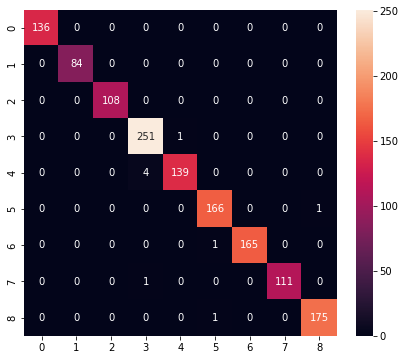

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       136
           1       1.00      1.00      1.00        84
           2       1.00      1.00      1.00       108
           3       0.98      1.00      0.99       252
           4       0.99      0.97      0.98       143
           5       0.99      0.99      0.99       167
           6       1.00      0.99      1.00       166
           7       1.00      0.99      1.00       112
           8       0.99      0.99      0.99       176

    accuracy                           0.99      1344
   macro avg       1.00      0.99      0.99      1344
weighted avg       0.99      0.99      0.99      1344



In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

In [ ]:
model.save('/content/key_points_classifier.hdf5', include_optimizer=False)

In [ ]:
tflite_save_path = '/content/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmpgc9byg8t/assets


INFO:tensorflow:Assets written to: /tmp/tmpgc9byg8t/assets


6672

In [ ]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [ ]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
X_test = X_test.astype('float32')

In [ ]:
X_test.dtypes

In [ ]:
interpreter.set_tensor(
    input_details[0]['index'], 
    np.array([X_test.iloc[0]])
    )


In [ ]:
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

In [ ]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[8.4747905e-01 5.7669382e-07 1.5251969e-01 2.2228055e-09 3.8425740e-10
 6.4416184e-07 1.8495981e-09 5.0163348e-26 1.7512828e-15]
0
